In [1]:
import io
import re
import zipfile
from collections import OrderedDict

from PIL import Image
from tqdm import tqdm
import numpy as np
from IPython.display import display

In [2]:
def extract_images_bytes(path_64='train_64.zip', path='../CatDog/train.zip'):
    labels_images = OrderedDict()
    # load 64
    z = zipfile.ZipFile(path_64, 'r')
    for file in z.filelist:
        m = re.match('.*(cat|dog).*', file.filename)
        if m:
            category = m.groups()[0]
            if category != 'cat': continue
            img = Image.open(io.BytesIO((z.open(file.filename).read())))
            label = re.sub('[^/]+/', '', file.filename)
            labels_images[label] = [img]
    # load origin
    z = zipfile.ZipFile(path, 'r')
    for file in z.filelist:
        m = re.match('.*(cat|dog).*', file.filename)
        if m:
            category = m.groups()[0]
            if category != 'cat': continue
            label = re.sub('[^/]+/', '', file.filename)
            if label not in labels_images: continue
            img = Image.open(io.BytesIO((z.open(file.filename).read())))
            labels_images[label].append(img)
    return labels_images

In [3]:
train = extract_images_bytes()

In [4]:
X_train = np.array([np.array(x[0]) for x in train.values()])
y_train = np.array([np.array(x[1]) for x in train.values()])

In [5]:
test = extract_images_bytes('test_64.zip', '../CatDog/test.zip')

In [6]:
X_test = np.array([np.array(x[0]) for x in test.values()])
y_test = np.array([np.array(x[1]) for x in test.values()])

In [7]:
# X_train = X_train / 255.0
# y_train = y_train / 255.0
# X_test = X_test / 255.0
# y_test = y_test / 255.0

In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 64, 64, 3) (10000, 128, 128, 3) (2500, 64, 64, 3) (2500, 128, 128, 3)


In [9]:
import tensorflow as tf

In [10]:
batch_size = 32
learning_rate = 0.01

In [11]:
X = tf.placeholder(tf.float32, [batch_size, 64, 64, 3], name='X')
y = tf.placeholder(tf.float32, [batch_size, 128, 128, 3], name='y')

In [12]:
pitch_1 = tf.Variable(tf.random_normal([1, 1, 3, 3], stddev=1e-1), name='pitch_1')
pitch_1_bias = tf.Variable(tf.random_normal([3], stddev=1e-1), name='pitch_1_bias')

In [13]:
dconv = tf.nn.bias_add(
    tf.nn.conv2d_transpose(
        X, pitch_1,
        (batch_size, 128, 128, 3),
        (1, 2, 2, 1),
        padding='SAME',
        data_format='NHWC'
    ),
    pitch_1_bias,
    name='bias_add_1'
)

In [14]:
dconv.get_shape()

TensorShape([Dimension(32), Dimension(128), Dimension(128), Dimension(3)])

In [15]:
pitch_2 = tf.Variable(tf.random_normal([9, 9, 3, 32], stddev=1e-1), name='pitch_2')
pitch_2_bias = tf.Variable(tf.random_normal([32], stddev=1e-1), name='pitch_2_bias')

In [16]:
conv_1 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(
            dconv, pitch_2, strides=[1, 1, 1, 1], padding='SAME'
        ),
        pitch_2_bias,
        name='bias_add_2'
    ),
    name='relu_2'
)

In [17]:
conv_1.get_shape()

TensorShape([Dimension(32), Dimension(128), Dimension(128), Dimension(32)])

In [18]:
pitch_3 = tf.Variable(tf.random_normal([1, 1, 32, 32], stddev=1e-1), name='pitch_3')
pitch_3_bias = tf.Variable(tf.random_normal([32], stddev=1e-1), name='pitch_3_bias')

In [19]:
conv_2 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(
            conv_1, pitch_3, strides=[1, 1, 1, 1], padding='SAME'
        ),
        pitch_3_bias,
        name='bias_add_3'
    )
)

In [20]:
conv_2.get_shape()

TensorShape([Dimension(32), Dimension(128), Dimension(128), Dimension(32)])

In [61]:
pitch_4 = tf.Variable(tf.random_normal([5, 5, 32, 3], stddev=1e-1), name='pitch_3')
pitch_4_bias = tf.Variable(tf.random_normal([3], stddev=1e-1), name='pitch_3_bias')

In [62]:
conv_3 = tf.nn.bias_add(
    tf.nn.conv2d(
        conv_2, pitch_4, strides=[1, 1, 1, 1], padding='SAME'
    ),
    pitch_4_bias,
    name='bias_add_4'
)

In [63]:
conv_3.get_shape()

TensorShape([Dimension(32), Dimension(128), Dimension(128), Dimension(3)])

In [64]:
pred = conv_3

In [65]:
cost = tf.reduce_mean(tf.pow(tf.sub(dconv, y), 2.0))

In [66]:
opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [67]:
init = tf.global_variables_initializer()

In [68]:
def batch_flow(inputs, targets, batch_size):
    """流动数据流"""
    flowed = 0
    total = len(inputs)
    while True:
        X_ret = []
        y_ret = []
        for i in range(total):
            X_ret.append(inputs[i])
            y_ret.append(targets[i])
            if len(X_ret) == batch_size:
                flowed += batch_size
                X, y = np.array(X_ret), np.array(y_ret)
                yield X, y
                X_ret = []
                y_ret = []
            if flowed >= total:
                break
        if flowed >= total:
            break

In [69]:
for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
    print(batch_x.shape, batch_y.shape)
    break

(32, 64, 64, 3) (32, 128, 128, 3)


In [74]:
n_epoch = 100

In [75]:
with tf.Session() as sess:
    sess.run(init)
    total = None
    for epoch in range(n_epoch):
        costs = []
        for batch_x, batch_y in tqdm(batch_flow(X_train, y_train, batch_size), total=total):
            _, c = sess.run([opt, cost], feed_dict={X: batch_x, y: batch_y})
            costs.append(c)
        print('epoch: {}, loss: {:.4f}'.format(epoch, np.mean(costs)))
        if total is None:
            total = len(costs)
    print('calculate train accuracy')
    costs = []
    train_result = []
    for batch_x, batch_y in tqdm(batch_flow(X_train, y_train, batch_size)):
        c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
        costs.append(c)
        train_result += list(p)
    print('test loss: {:.4f}'.format(np.mean(costs)))
    print('calculate test accuracy')
    costs = []
    test_result = []
    for batch_x, batch_y in tqdm(batch_flow(X_test, y_test, batch_size)):
        c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
        costs.append(c)
        test_result += list(p)
    print('test loss: {:.4f}'.format(np.mean(costs)))
    print('Done')

313it [00:09, 32.96it/s]0:00, 19.91it/s]
  1%|▏         | 4/313 [00:00<00:10, 30.45it/s]

epoch: 0, loss: 13363.4668


  1%|▏         | 4/313 [00:00<00:08, 35.85it/s]

epoch: 1, loss: 12509.5625


  1%|▏         | 4/313 [00:00<00:08, 36.17it/s]

epoch: 2, loss: 12007.7334


  1%|▏         | 4/313 [00:00<00:08, 36.17it/s]

epoch: 3, loss: 11530.8262


  1%|▏         | 4/313 [00:00<00:08, 35.95it/s]

epoch: 4, loss: 11075.9619


  1%|▏         | 4/313 [00:00<00:08, 35.61it/s]

epoch: 5, loss: 10640.3818


  1%|▏         | 4/313 [00:00<00:08, 34.64it/s]

epoch: 6, loss: 10222.6553


  1%|▏         | 4/313 [00:00<00:08, 36.02it/s]

epoch: 7, loss: 9821.9707


  1%|▏         | 4/313 [00:00<00:08, 36.38it/s]

epoch: 8, loss: 9437.7217


  1%|▏         | 4/313 [00:00<00:08, 35.93it/s]

epoch: 9, loss: 9069.4023


  1%|▏         | 4/313 [00:00<00:08, 35.07it/s]

epoch: 10, loss: 8716.5732


  1%|▏         | 4/313 [00:00<00:08, 35.82it/s]

epoch: 11, loss: 8378.8613


  1%|▏         | 4/313 [00:00<00:08, 35.58it/s]

epoch: 12, loss: 8055.9360


  1%|▏         | 4/313 [00:00<00:08, 35.87it/s]

epoch: 13, loss: 7747.5098


  1%|▏         | 4/313 [00:00<00:08, 35.97it/s]

epoch: 14, loss: 7453.3276


  1%|▏         | 4/313 [00:00<00:08, 35.94it/s]

epoch: 15, loss: 7173.1631


  1%|▏         | 4/313 [00:00<00:08, 35.96it/s]

epoch: 16, loss: 6906.8081


  1%|▏         | 4/313 [00:00<00:08, 36.11it/s]

epoch: 17, loss: 6654.0713


  1%|▏         | 4/313 [00:00<00:08, 35.99it/s]

epoch: 18, loss: 6414.7725


  1%|▏         | 4/313 [00:00<00:09, 34.06it/s]

epoch: 19, loss: 6188.7349


  1%|▏         | 4/313 [00:00<00:08, 34.74it/s]

epoch: 20, loss: 5975.7837


  1%|▏         | 4/313 [00:00<00:08, 34.53it/s]

epoch: 21, loss: 5775.7451


  1%|▏         | 4/313 [00:00<00:08, 34.58it/s]

epoch: 22, loss: 5588.4429


  1%|▏         | 4/313 [00:00<00:08, 35.12it/s]

epoch: 23, loss: 5413.6909


  1%|▏         | 4/313 [00:00<00:08, 34.84it/s]

epoch: 24, loss: 5251.2915


  1%|▏         | 4/313 [00:00<00:08, 34.39it/s]

epoch: 25, loss: 5101.0332


  1%|▏         | 4/313 [00:00<00:08, 34.87it/s]

epoch: 26, loss: 4962.6836


  1%|▏         | 4/313 [00:00<00:08, 34.72it/s]

epoch: 27, loss: 4835.9902


  1%|▏         | 4/313 [00:00<00:08, 34.66it/s]

epoch: 28, loss: 4720.6743


  1%|▏         | 4/313 [00:00<00:08, 35.01it/s]

epoch: 29, loss: 4616.4287


  1%|▏         | 4/313 [00:00<00:08, 35.57it/s]

epoch: 30, loss: 4522.9111


  1%|▏         | 4/313 [00:00<00:08, 35.27it/s]

epoch: 31, loss: 4439.7461


  1%|▏         | 4/313 [00:00<00:09, 33.55it/s]

epoch: 32, loss: 4366.5122


  1%|▏         | 4/313 [00:00<00:08, 34.43it/s]

epoch: 33, loss: 4302.7412


  1%|▏         | 4/313 [00:00<00:08, 34.97it/s]

epoch: 34, loss: 4247.9146


  1%|▏         | 4/313 [00:00<00:08, 34.96it/s]

epoch: 35, loss: 4201.4546


  1%|▏         | 4/313 [00:00<00:08, 35.30it/s]

epoch: 36, loss: 4162.7275


  1%|▏         | 4/313 [00:00<00:08, 35.04it/s]

epoch: 37, loss: 4131.0444


  1%|▏         | 4/313 [00:00<00:08, 34.49it/s]

epoch: 38, loss: 4105.6631


  1%|▏         | 4/313 [00:00<00:08, 35.52it/s]

epoch: 39, loss: 4085.8042


  1%|▏         | 4/313 [00:00<00:08, 34.97it/s]

epoch: 40, loss: 4070.6694


  1%|▏         | 4/313 [00:00<00:08, 35.41it/s]

epoch: 41, loss: 4059.4666


  1%|▏         | 4/313 [00:00<00:08, 34.71it/s]

epoch: 42, loss: 4051.4380


  1%|▏         | 4/313 [00:00<00:08, 35.39it/s]

epoch: 43, loss: 4045.8877


  1%|▏         | 4/313 [00:00<00:09, 33.89it/s]

epoch: 44, loss: 4042.2017


  1%|▏         | 4/313 [00:00<00:09, 32.33it/s]

epoch: 45, loss: 4039.8601


  1%|▏         | 4/313 [00:00<00:09, 31.96it/s]

epoch: 46, loss: 4038.4453


  1%|▏         | 4/313 [00:00<00:08, 35.91it/s]

epoch: 47, loss: 4037.6357


  1%|▏         | 4/313 [00:00<00:08, 35.71it/s]

epoch: 48, loss: 4037.1978


  1%|▏         | 4/313 [00:00<00:08, 36.00it/s]

epoch: 49, loss: 4036.9753


  1%|▏         | 4/313 [00:00<00:08, 36.07it/s]

epoch: 50, loss: 4036.8674


  1%|▏         | 4/313 [00:00<00:09, 33.04it/s]

epoch: 51, loss: 4036.8186


  1%|▏         | 4/313 [00:00<00:08, 36.21it/s]

epoch: 52, loss: 4036.7971


  1%|▏         | 4/313 [00:00<00:08, 35.83it/s]

epoch: 53, loss: 4036.7871


  1%|▏         | 4/313 [00:00<00:09, 33.13it/s]

epoch: 54, loss: 4036.7834


  1%|▏         | 4/313 [00:00<00:08, 35.20it/s]

epoch: 55, loss: 4036.7820


  1%|▏         | 4/313 [00:00<00:08, 35.66it/s]

epoch: 56, loss: 4036.7808


  1%|▏         | 4/313 [00:00<00:08, 35.36it/s]

epoch: 57, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.24it/s]

epoch: 58, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.03it/s]

epoch: 59, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.36it/s]

epoch: 60, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 35.93it/s]

epoch: 61, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 34.83it/s]

epoch: 62, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 36.14it/s]

epoch: 63, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:09, 33.74it/s]

epoch: 64, loss: 4036.7795


  1%|▏         | 4/313 [00:00<00:09, 33.58it/s]

epoch: 65, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:09, 32.68it/s]

epoch: 66, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 34.78it/s]

epoch: 67, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:09, 33.53it/s]

epoch: 68, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 36.22it/s]

epoch: 69, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:09, 33.83it/s]

epoch: 70, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 35.41it/s]

epoch: 71, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.38it/s]

epoch: 72, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.53it/s]

epoch: 73, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 35.53it/s]

epoch: 74, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 36.11it/s]

epoch: 75, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.87it/s]

epoch: 76, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.16it/s]

epoch: 77, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.48it/s]

epoch: 78, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 34.53it/s]

epoch: 79, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.96it/s]

epoch: 80, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 36.15it/s]

epoch: 81, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.58it/s]

epoch: 82, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 35.78it/s]

epoch: 83, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 36.06it/s]

epoch: 84, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 35.02it/s]

epoch: 85, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 34.68it/s]

epoch: 86, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:09, 34.23it/s]

epoch: 87, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 34.72it/s]

epoch: 88, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:09, 34.19it/s]

epoch: 89, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 34.49it/s]

epoch: 90, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 34.43it/s]

epoch: 91, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 34.59it/s]

epoch: 92, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 34.86it/s]

epoch: 93, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:09, 33.83it/s]

epoch: 94, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:09, 34.29it/s]

epoch: 95, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 34.36it/s]

epoch: 96, loss: 4036.7803


  1%|▏         | 4/313 [00:00<00:08, 34.77it/s]

epoch: 97, loss: 4036.7800


  1%|▏         | 4/313 [00:00<00:08, 34.59it/s]

epoch: 98, loss: 4036.7800


100%|██████████| 313/313 [00:08<00:00, 34.86it/s]4%|▍         | 12/313 [00:00<00:08, 34.34it/s]
2it [00:00, 15.76it/s]

epoch: 99, loss: 4036.7803
calculate train accuracy


313it [00:18, 16.54it/s]t [00:00, 16.06it/s]
2it [00:00, 16.17it/s]

test loss: 4035.7788
calculate test accuracy


79it [00:04, 16.47it/s]it [00:00, 16.09it/s]

test loss: 4117.8384
Done


In [76]:
def disp(n, times=255.0):
    display(
        Image.fromarray(np.uint8(X_train[n] * times)).resize((128, 128), Image.ANTIALIAS),
        Image.fromarray(np.uint8(train_result[n] * times)),
        Image.fromarray(np.uint8(y_train[n] * times))
    )

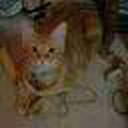

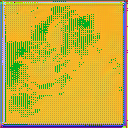

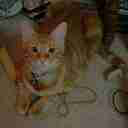

In [77]:
disp(0, 1.0)